# Introduction
Use this notebook to generate manhattan plots from the matrix eQTL results.

# Setup

In [1]:
import scanpy as sc
import pandas as pd
from IPython.display import display 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

from tqdm.notebook import tqdm
import warnings
import itertools as it
import json
import requests
import re
from copy import copy
import seaborn as sns
import pickle as pkl
from functools import reduce
import anndata
import gzip
import pybedtools
from joblib import Parallel, delayed
from multiprocessing import cpu_count
from scipy import stats
from scipy.signal import savgol_filter
from scipy.spatial import distance
from scipy.interpolate import interp1d
from joblib import Parallel, delayed
from multiprocessing import cpu_count
import subprocess
import sys
import os

In [2]:
mountpoint = '/data/clue/'
prefix_prod = mountpoint + 'prod/'
prefix_pks = mountpoint + 'amo/atac/peaks/'
prefix_eqtl = mountpoint + 'prod/eqtl/'

# Load Data

In [3]:
path = prefix_eqtl + 'mateqtl/pkls/mdsr.pkl'
# mdsr.to_pickle(path)
mdsr = pd.read_pickle(path)

In [4]:
with open(mountpoint + 'meta.pkl', 'rb') as file:
    meta = pkl.load(file)

In [5]:
cond_cts = meta['eqtl']['cond_cts']
ct_colors = meta['ct_colors']['ct5']['hex']
cond_colors = meta['cond_colors']['hex']
ct_idx_dict = dict([(v, k) for k, v in enumerate(cond_cts['ct'].cat.categories)])

# Manhattan Plots

In [6]:
# from here: https://www.ncbi.nlm.nih.gov/grc/human/data
chrom_lengths = {1: 249250621, 2: 243199373, 3: 198022430, 4: 191154276, 5: 180915260, 
                 6: 171115067, 7: 159138663, 8: 146364022, 9: 141213431, 10: 135534747, 
                 11: 135006516, 12: 133851895, 13: 115169878, 14: 107349540, 15: 102531392, 
                 16: 90354753, 17: 81195210, 18: 78077248, 19: 59128983, 20: 63025520, 
                 21: 48129895, 22: 51304566}

In [7]:
c_chrl = {0: 0, 1: chrom_lengths[1]} # c_chrl = cumulative_chrom_lengths
for chrom in range(2, 23):
    c_chrl[chrom] = sum([chrom_lengths[c] for c in range(1, chrom + 1)])

In [8]:
mdsr['snp_pos_total'] = mdsr['snp_pos'].copy()

In [9]:
for chrom in tqdm(range(2, 23)):
    idxs = mdsr.index[mdsr['snp_chrom'] == chrom]
    mdsr.loc[idxs, 'snp_pos_total'] =  (mdsr.loc[idxs, 'snp_pos_total'] + c_chrl[chrom - 1]).values

In [10]:
sig_t = -np.log10(2.764614278341353e-05)
logp = mdsr['-log10p']
fdr = logp > sig_t

In [11]:
gw = int(2.5e7) # gw = genome_window
bins = np.arange(0, int(3e9), step=gw)
num_bins = len(bins)
average_pos = np.arange(int(gw/2), int(3e9), step=gw)
bin_pos_map = dict(zip(range(int(3e9/gw)), average_pos))

B_Mem


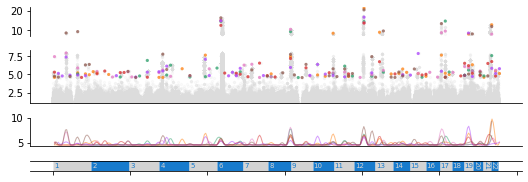

B_Naive


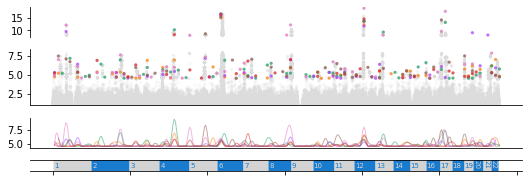

MAIT


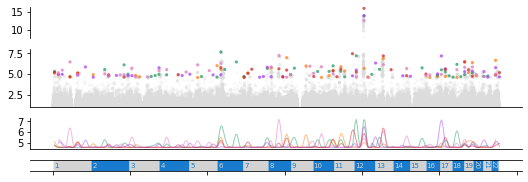

NK


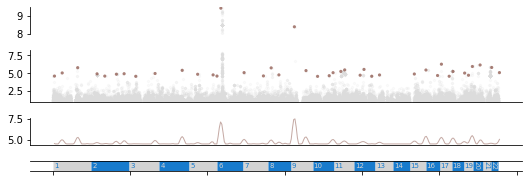

NK_CD16+


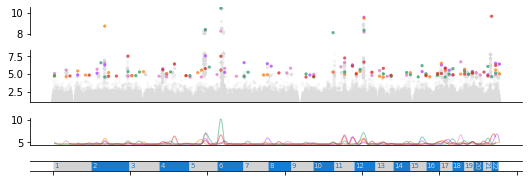

NK_CD56++


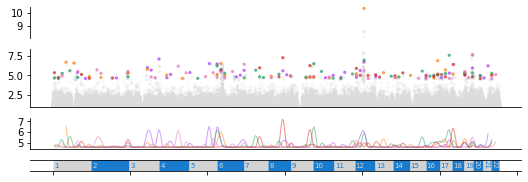

T4_EM


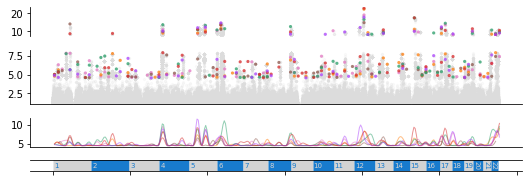

T4_Naive


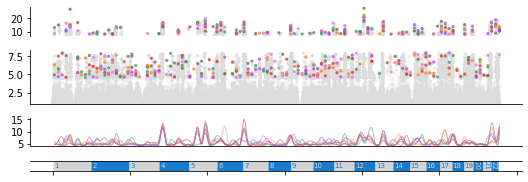

T8_Mem


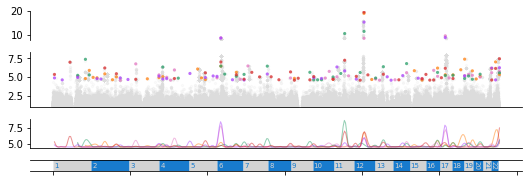

T8_Naive


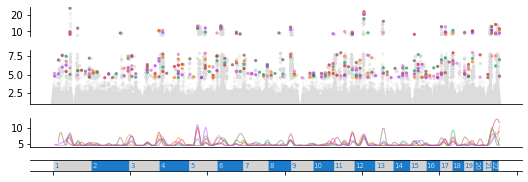

T_Tox


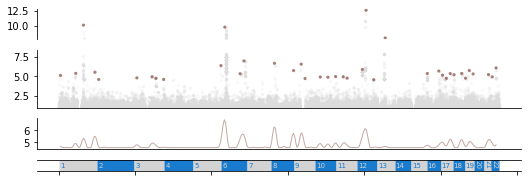

T_gd


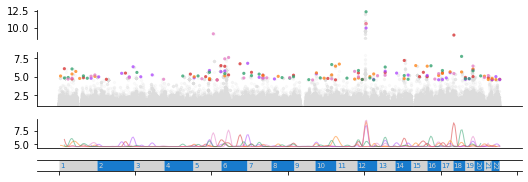

cDC


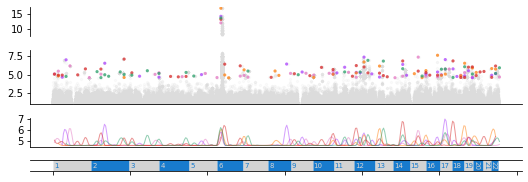

cM


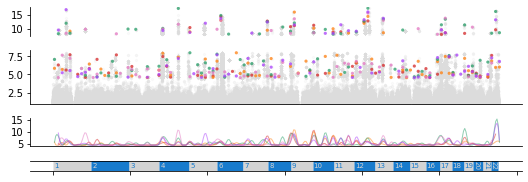

ncM


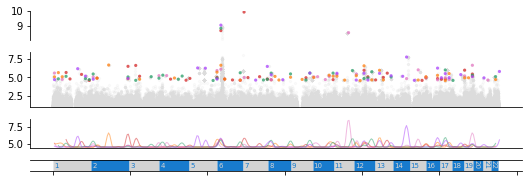

pDC


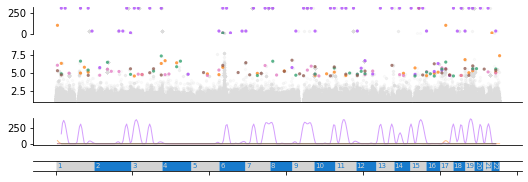

In [12]:
frac = 0.05 # smaller values will make it plot faster, just use for testing, change to 1 for final figures
ignore = [
#     ('myeloid_cells', 'P'),
#     ('T4_Mem', 'P'),
#     ('HSC', 'C')
    
]
high_sig_t = 8

for ct in cond_cts['ct'].cat.categories:
    print(ct)
    fig, ax = plt.subplots(4, 1, figsize=(7.5,3), sharex=True, gridspec_kw={'height_ratios': [0.8, 1.5, 0.8, 0.3]})
    ax0, ax1, ax2, ax3 = ax[0], ax[1], ax[2], ax[3]
    manhat_plot_dict = dict()
    conds = cond_cts[cond_cts['ct'] == ct]['cond'].unique()
    for cond in conds:
        manhat_plot_dict[cond] = dict()
        df1 = logp.xs((ct, cond), axis=1).rename('-log10p').to_frame()
        df2 = fdr.xs((ct, cond), axis=1).rename('FDR').to_frame()

        manhat_plot = pd.concat([df1, df2, mdsr.loc[:, 'snp_pos_total']], axis=1)
        sig_bool = manhat_plot['FDR'].values
        manhat_plot_sig = manhat_plot[sig_bool].copy()
        
        if frac < 1:
            manhat_plot = pd.concat([manhat_plot_sig, manhat_plot[~sig_bool].sample(frac=frac)], axis=0)
        
        manhat_plot_high_sig = manhat_plot[manhat_plot['-log10p'] >= high_sig_t]
        manhat_plot_low_sig = manhat_plot[manhat_plot['-log10p'] < high_sig_t]
        
        manhat_plot_dict[cond]['all_high_sig'] = (manhat_plot_high_sig['snp_pos_total'].values, manhat_plot_high_sig['-log10p'].values)
        manhat_plot_dict[cond]['all_low_sig'] = (manhat_plot_low_sig['snp_pos_total'].values, manhat_plot_low_sig['-log10p'].values)
        
        if (ct, cond) in ignore: # because it doesn't exist, it creates problems
            continue 
        manhat_plot_sig['snp_pos_total_bin'] = np.digitize(manhat_plot_sig['snp_pos_total'].values, bins=bins)
        gb = manhat_plot_sig.groupby('snp_pos_total_bin')['-log10p']
        vals = pd.concat([gb.max(), gb.median()], axis=1, keys=['max', 'median'])
        
        vals_no_added = vals.sort_index()
        vals_no_added.index = vals_no_added.index.map(lambda x: bin_pos_map[x - 1])
        
        add_vals = np.setdiff1d(range(vals.index.values.min(), vals.index.values.max()), vals.index.values)
        vals_with_added = vals.append(pd.DataFrame(data=manhat_plot_sig['-log10p'].min(), index=add_vals, columns=['max', 'median'])).sort_index()
        vals_with_added.index = vals_with_added.index.map(lambda x: bin_pos_map[x - 1])
        
        manhat_plot_dict[cond]['high_sig_no_added'] = vals_no_added[vals_no_added['max'] >= high_sig_t]
        manhat_plot_dict[cond]['low_sig_no_added'] = vals_no_added[vals_no_added['max'] < high_sig_t]
        manhat_plot_dict[cond]['sig_with_added'] = vals_with_added
#     break
    for cond in conds:
        ax0.scatter(*manhat_plot_dict[cond]['all_high_sig'], c='gainsboro', s=5, alpha=0.1)
        ax1.scatter(*manhat_plot_dict[cond]['all_low_sig'], c='gainsboro', s=5, alpha=0.1)
    ax1.set_ylim((1, ax1.get_ylim()[1]))
    for cond in conds:
        if (ct, cond) in ignore: # because it doesn't exist, it creates problems
            continue 
        ax0.scatter(*manhat_plot_dict[cond]['high_sig_no_added']['max'].reset_index().T.values, c=cond_colors[cond], s=10, edgecolors='none', alpha=0.75)
        ax1.scatter(*manhat_plot_dict[cond]['low_sig_no_added']['max'].reset_index().T.values, c=cond_colors[cond], s=10, edgecolors='none', alpha=0.75)
        
        x, y = manhat_plot_dict[cond]['sig_with_added']['median'].reset_index().T.values
        f2 = interp1d(x, y, kind='cubic')
        
        newx = np.linspace(x.min(), x.max(), num_bins*3)
        newy = np.clip(f2(newx), y.min(), np.inf)
        
        ax2.plot(newx, newy, c=cond_colors[cond], linewidth=1, alpha=0.5)
#         ax1.scatter(*manhat_plot_dict[cond]['sig']['median'].reset_index().T.values, c=cond_colors[cond], s=1, alpha=0.5)
            
    chrom_color = it.cycle(['#D3D3D3', '#187bcd'])
    chrom_bar_linewidth = 15
    ax3.plot([0, c_chrl[1]], [0, 0], c=next(chrom_color), linewidth=chrom_bar_linewidth, solid_capstyle='butt')
    for chrom in range(2, 23):
        ax3.plot([c_chrl[chrom - 1], c_chrl[chrom]], [0, 0], 
                 c=next(chrom_color), linewidth=chrom_bar_linewidth, solid_capstyle='butt')
    chrom_name_color = it.cycle(['#187bcd', '#D3D3D3'])
    for chrom in range(1, 23):
        if chrom >= 20:
            ha, va, y, rot = 'left', 'center', 0.02, -90
        else:
            ha, va, y, rot = 'left', 'center', 0, 0
        ax3.text(c_chrl[chrom - 1] + (chrom_lengths[chrom]*0.05), y, s=str(chrom), color=next(chrom_name_color), size=7, va='center', ha='left', rotation=rot)
    ax3.set_ylim((-0.1, 0.1))
    ax3.set_yticks([])

    for ax_ in [ax0, ax1, ax2]:
        ax_.tick_params(axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,         # ticks along the top edge are off
                        labelbottom=False)
        for spine in ['top', 'right']:
            ax_.spines[spine].set_visible(False)
    ax0.spines['bottom'].set_visible(False)
    for spine in ['left', 'right']:
        ax3.spines[spine].set_visible(False)
    plt.tight_layout()
    
#     if ct not in ['B_cells', 'myeloid_cells']:
#         ax3.set_xticklabels([])
    plt.show()